## Emojifier-V1

In [7]:
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt

%matplotlib inline

### Dataset

In [8]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [9]:
maxLen = len(max(X_train, key=len).split())

In [14]:
for idx in range(10):
    print(X_train[idx], emoji.emojize(emoji_dictionary[str(Y_train[idx])]))

never talk to me again :disappointed:

I am proud of your achievements :smile:

It is the worst day in my life :disappointed:

Miss you so much ❤️

food is life 🍴

I love you mum ❤️

Stop saying bullshit :disappointed:

congratulations on your acceptance :smile:

The assignment is too long  :disappointed:

I want to go play ⚾



In [16]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [18]:
idx = 50
print(f"Sentence '{X_train[idx]}' has label index {Y_train[idx]}, which is emoji {emoji.emojize(emoji_dictionary[str(Y_train[idx])])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I missed you' has label index 0, which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0.]


In [22]:
words = set()
word_to_vec_map = {}

with open('data/glove.6B.50d.txt', 'r', encoding='UTF-8') as f: 
    file = f.readlines()
    
for line in file:
    line = line.strip().split()
    curr_word = line[0]
    words.add(curr_word)
    word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

i = 1
words_to_index = {}
index_to_words = {}
for w in sorted(words):
    words_to_index[w] = i
    index_to_words[i] = w
    i = i + 1

In [25]:
word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", words_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_words[idx])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


In [26]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (J,), where J can be any number
    """
    # Get a valid word contained in the word_to_vec_map. 
    any_word = list(word_to_vec_map.keys())[0]

    # Split sentence into list of lower case words
    words = sentence.lower().split()

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros(len(word_to_vec_map[any_word]))
    
    # Initialize count to 0
    count = 0
    
    # average the word vectors. You can loop over the words in the list "words".
    for w in words:
        # Check that word exists in word_to_vec_map
        if w in word_to_vec_map.keys():
            avg += word_to_vec_map[w]
            # Increment count
            count +=1
          
    if count > 0:
        # Get the average. But only if count > 0
        avg = avg / count
    
    return avg

### Model

In [27]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m,)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    # Get a valid word contained in the word_to_vec_map 
    any_word = list(word_to_vec_map.keys())[0]
        
    # Define number of training examples
    m = Y.shape[0]                             # number of training examples
    n_y = len(np.unique(Y))                    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0]   # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        
        cost = 0
        dW = 0
        db = 0
        
        for i in range(m):          # Loop over the training examples
            
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer. 
            # You can use np.dot() to perform the multiplication.
            z = np.dot(W, avg) + b
            a = softmax(z)

            # Add the cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost += -np.sum(Y_oh * np.log(a))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW += np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db += dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emo_utils.py

    return pred, W, b

In [28]:
np.random.seed(1)
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred[:5])

Epoch: 0 --- cost = 73708.16886577604
Accuracy: 0.5454545454545454
Epoch: 100 --- cost = 583827.7397310248
Accuracy: 0.946969696969697
Epoch: 200 --- cost = 641508.0398914787
Accuracy: 1.0
Epoch: 300 --- cost = 641479.1853353204
Accuracy: 1.0
[[3.]
 [2.]
 [3.]
 [0.]
 [4.]
 [0.]
 [3.]
 [2.]
 [3.]
 [1.]
 [3.]
 [3.]
 [1.]
 [3.]
 [2.]
 [3.]
 [2.]
 [3.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [1.]
 [4.]
 [2.]
 [2.]
 [4.]
 [0.]
 [3.]
 [4.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [3.]
 [4.]
 [2.]
 [2.]
 [0.]
 [2.]
 [3.]
 [0.]
 [3.]
 [2.]
 [4.]
 [3.]
 [0.]
 [3.]
 [3.]
 [3.]
 [4.]
 [2.]
 [1.]
 [1.]
 [1.]
 [2.]
 [3.]
 [1.]
 [0.]
 [0.]
 [0.]
 [3.]
 [4.]
 [4.]
 [2.]
 [2.]
 [1.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [0.]
 [0.]
 [3.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [4.]
 [3.]
 [3.]
 [2.]
 [4.]
 [0.]
 [0.]
 [0.]
 [3.]
 [3.]
 [3.]
 [2.]
 [0.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [3.]
 [2.]
 [2.]
 [2.]
 [4.]
 [1.]
 [1.]
 [3.]
 [3.]
 [4.]
 [1.]
 [2.]
 [1.]
 [1.]
 [3.]
 [1.]
 [0.]
 [4.]
 [0.]
 [3.]
 [3.]
 [4.]
 

In [29]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 1.0
Test set:
Accuracy: 0.8928571428571429


In [66]:
X_my_sentences = np.array(["i cherish you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)

Accuracy: 0.8333333333333334


Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            5    1    0    1    0    7
1            0    8    0    0    0    8
2            1    0   17    0    0   18
3            1    0    2   13    0   16
4            0    0    0    0    7    7
All          7    9   19   14    7   56


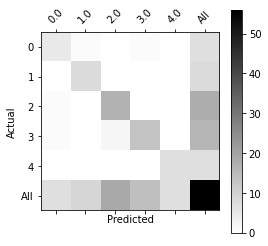

In [67]:
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

<font color='blue'><b>What you should remember:</b>
- Even with a mere 127 training examples, you can get a reasonably good model for Emojifying. 
    - This is due to the generalization power word vectors gives you. 
- Emojify-V1 will perform poorly on sentences such as *"This movie is not good and not enjoyable"* 
    - It doesn't understand combinations of words.
    - It just averages all the words' embedding vectors together, without considering the ordering of words. 
</font>

## Emojifier-V2

In [36]:
import numpy as np
import tensorflow
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)

### sentences_to_indices

In [37]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m,)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words

        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index.keys():
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j =  j + 1
    
    return X_indices

In [39]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, words_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


### pretrained_embedding_layer

In [40]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding (requirement)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of your GloVe word vectors (= 50)

    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros((vocab_size, emb_dim))
    
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=emb_dim, trainable=False)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [41]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, words_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim",embedding_layer.output_dim)

weights[0][1][1] = 0.39031
Input_dim 400001
Output_dim 50


### Model

In [43]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with 5 units
    X = Dense(5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [45]:
model = Emojify_V2((maxLen,), word_to_vec_map, words_to_index)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 10, 50)            20000050  
                                                                 
 lstm (LSTM)                 (None, 10, 128)           91648     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 5)                 645   

In [46]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
X_train_indices = sentences_to_indices(X_train, words_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

In [49]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
5/5 [==============================] - 2s 11ms/step - loss: 1.5607 - accuracy: 0.2803
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 1.4952 - accuracy: 0.2879
Epoch 3/50
5/5 [==============================] - 0s 8ms/step - loss: 1.4269 - accuracy: 0.3636
Epoch 4/50
5/5 [==============================] - 0s 8ms/step - loss: 1.3365 - accuracy: 0.4015
Epoch 5/50
5/5 [==============================] - 0s 8ms/step - loss: 1.2315 - accuracy: 0.5682
Epoch 6/50
5/5 [==============================] - 0s 8ms/step - loss: 1.1216 - accuracy: 0.5985
Epoch 7/50
5/5 [==============================] - 0s 8ms/step - loss: 0.9461 - accuracy: 0.6364
Epoch 8/50
5/5 [==============================] - 0s 8ms/step - loss: 0.8850 - accuracy: 0.6742
Epoch 9/50
5/5 [==============================] - 0s 8ms/step - loss: 0.8302 - accuracy: 0.6667
Epoch 10/50
5/5 [==============================] - 0s 8ms/step - loss: 0.7720 - accuracy: 0.6970
Epoch 11/50
5/5 [=====================

In [51]:
X_test_indices = sentences_to_indices(X_test, words_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 1s 4ms/step - loss: 0.5823 - accuracy: 0.8036

Test accuracy =  0.8035714030265808


In [57]:
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, words_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji / Prediction - '+ emoji.emojize(emoji_dictionary[str(Y_test[i])]) + " / " + emoji.emojize(emoji_dictionary[str(num)]) + 
              ' - Sentence : '+ X_test[i])

Expected emoji / Prediction - :disappointed: / :smile: - Sentence : work is hard	
Expected emoji / Prediction - :disappointed: / :smile: - Sentence : This girl is messing with me	
Expected emoji / Prediction - :disappointed: / :smile: - Sentence : work is horrible	
Expected emoji / Prediction - 🍴 / :smile: - Sentence : any suggestions for dinner	
Expected emoji / Prediction - ❤️ / :disappointed: - Sentence : I love taking breaks	
Expected emoji / Prediction - :disappointed: / :smile: - Sentence : she is a bully	
Expected emoji / Prediction - ❤️ / :smile: - Sentence : My grandmother is the love of my life	
Expected emoji / Prediction - ❤️ / :smile: - Sentence : I miss you so much	
Expected emoji / Prediction - ❤️ / :smile: - Sentence : i miss her	
Expected emoji / Prediction - ❤️ / ⚾ - Sentence : I love you to the stars and back	
Expected emoji / Prediction - :disappointed: / ⚾ - Sentence : go away	


In [65]:
x_test = np.array(["I cannot swim"])
X_test_indices = sentences_to_indices(x_test, words_to_index, maxLen)
print(x_test[0] +' '+ emoji.emojize(emoji_dictionary[str(np.argmax(model.predict(X_test_indices)))]))

I cannot swim :disappointed:


<font color='blue'><b>What you should remember</b>:
- If you have an NLP task where the training set is small, using word embeddings can help your algorithm significantly. 
- Word embeddings allow your model to work on words in the test set that may not even appear in the training set. 
- Training sequence models in Keras (and in most other deep learning frameworks) requires a few important details:
    - To use mini-batches, the sequences need to be **padded** so that all the examples in a mini-batch have the **same length**. 
    - An `Embedding()` layer can be initialized with pretrained values. 
        - These values can be either fixed or trained further on your dataset. 
        - If however your labeled dataset is small, it's usually not worth trying to train a large pre-trained set of embeddings.   
    - `LSTM()` has a flag called `return_sequences` to decide if you would like to return every hidden states or only the last one. 
    - You can use `Dropout()` right after `LSTM()` to regularize your network. 